# B-alanine Side Learning Y-maze

## Load packages

In [1]:
require(reshape2) # For data handling
require(lme4) # Linear mixed-effects models
require(emmeans) # Post-hoc analysis on the model
require(DHARMa) # Evaluate model fit
require(AICcmodavg) # For model selection and averaging

Loading required package: reshape2

Loading required package: lme4

Loading required package: Matrix

Loading required package: emmeans

Loading required package: DHARMa

This is DHARMa 0.4.5. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa')

Loading required package: AICcmodavg


Attaching package: ‘AICcmodavg’


The following object is masked from ‘package:lme4’:

    checkConv




## Clean-up

In [2]:
rm(list = ls()) # Remove variables/objects
graphics.off() # Close any open graphics

## Load data

In [4]:
ELP = read.csv("./Data/All/ELP_all.csv")
ELP = subset(ELP, ELP$Experiment == "4") # Subset for B-alanine experiment
head(ELP, n = 1) # Check it was loaded correctly

,Collection_Date,Time_Collection,Experimentor,Temperature,Colony_Origin,Starvation_Period,Donor_Colony,Recipient_Colony,Ant_ID,Visit,⋯,Out_Duration,Bridge_Nest_Duration,Total_Duration_Minutes,Trophallaxis,Full,Experiment,Initial_Binary,Final_Binary,Switched_Binary,TSM_Bin
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>
901,02.05.22,09:17,Laura Neubauer,24.3,20th April - Portugal,4-days,56,57,1,2,⋯,11,480,8.7,NA,No,4,1,1,0,0-30


## Ensure relevant variables are factors

In [5]:
ELP$Collection_Date = as.factor(ELP$Collection_Date)
ELP$Experimentor = as.factor(ELP$Experimentor)
ELP$Starvation_Period = as.factor(ELP$Starvation_Period)
ELP$Colony_ID = as.factor(paste0(ELP$Donor_Colony, "_", ELP$Recipient_Colony))
ELP$Ant_ID = as.factor(ELP$Ant_ID)

ELP$Visit = as.factor(ELP$Visit)
ELP$Solution = as.factor(ELP$Solution)
ELP$Solution = relevel(ELP$Solution, "Control")
ELP$Reward_Side = as.factor(ELP$Reward_Side)
ELP$TSM_Bin = as.factor(ELP$TSM_Bin)

ELP$Initial_Binary = as.factor(ELP$Initial_Binary)
ELP$Final_Binary = as.factor(ELP$Final_Binary)

## Identify relevant random effects

In [6]:
unique(ELP$Collection_Date)
unique(ELP$Experimentor)
unique(ELP$Starvation_Period)
unique(ELP$Colony_ID)
unique(ELP$Ant_ID)

[1] 02.05.22 03.05.22 04.05.22 05.05.22 06.05.22 09.05.22 10.05.22 11.05.22
[9] 12.05.22
9 Levels: 02.05.22 03.05.22 04.05.22 05.05.22 06.05.22 09.05.22 ... 12.05.22

[1] Laura Neubauer
Levels: Laura Neubauer

[1] 4-days 5-days
Levels: 4-days 5-days

[1] 56_57 16_13 9_11 
Levels: 16_13 56_57 9_11

[1] 1  2  3  4  5  6  7  8  9  10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
[51] 51 52 53 54 55 56 57 58 59 60 61 62 63 64
64 Levels: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 ... 64

## Do initial and final choices significantly differ?

In [7]:
ELP_choice_diff = melt(ELP, measure.vars = c("Initial_Binary", "Final_Binary"))

ELP_choice_diff$variable = as.factor(ELP_choice_diff$variable)
ELP_choice_diff$value = as.factor(ELP_choice_diff$value)

ELP_choice_diff_mod = glmer(value ~ variable + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP_choice_diff, family = binomial, glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

e = emmeans(ELP_choice_diff_mod, ~variable, type = "response")
pairs(e)

boundary (singular) fit: see help('isSingular')



 contrast                      odds.ratio  SE  df null z.ratio p.value
 Initial_Binary / Final_Binary      0.956 0.2 Inf    1  -0.214  0.8309

Tests are performed on the log odds ratio scale 

p-value > 0.1 hence there is no statistical difference between initial and final decision therefore we will use final decision henceforth.

## Define models

### 1. Null model
**Biological hypothesis:** Ants randomly choose a Y-maze arm.

In [8]:
null_mod = glmer(Final_Binary ~ 1 + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 2. Visit model
**Biological hypothesis:** Ants learn to associate a Y-maze arm with a reward. Over consecutive visits more ants choose the correct arm.

In [9]:
visit_mod = glmer(Final_Binary ~ Visit + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 3. Solution model
**Biological hypothesis:** The presence of a psychoactive chemical in the reward alters the ants ability to choose a Y-maze arm.

In [10]:
solution_mod = glmer(Final_Binary ~ Solution + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 4. Side model
**Biological hypothesis:** Ants have an intrinsic predisposition towards turning left or right. This is associated with brain lateralisation which has been shown in multiple organisms.

In [11]:
side_mod = glmer(Final_Binary ~ Reward_Side + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 5. Time since marking model
**Biological hypothesis:** Ants that had a waiting period (>30 minutes) after learning the reward/side association have different recall strenght. This should be associated with long-term memory formation which should be stronger.

In [12]:
tsm_mod = glmer(Final_Binary ~ TSM_Bin + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 6. Solution and Visit with Time since marking model
**Biological hypothesis:** The effects of a psychoactive chemical might be time dependent.

In [13]:
solution_time_mod = glmer(Final_Binary ~ Solution + TSM_Bin + Visit + Solution:TSM_Bin + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 7. Maximal model
**Biological hypothesis:** All of the available variables contribute towards ant learning.

In [14]:
max_mod = glmer(Final_Binary ~ Solution + Visit + TSM_Bin + Reward_Side + Solution:TSM_Bin + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



## Model Selection

In [15]:
cand_models = list("null_mod" = null_mod, 
                   "visit_mod" = visit_mod,
                   "solution_mod" = solution_mod,
                   "side_mod" = side_mod,
                   "tsm_mod" = tsm_mod,
                   "solution_time_mod" = solution_time_mod,
                   "max_mod" = max_mod)

aictab(cand_models)
confset(cand.set = cand_models) # Remove models that explain the last 0.05 Cum.Wt

,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,side_mod,7,309.6082,0.000000,1.00000000,0.679758144,-147.5783,0.6797581
7,max_mod,13,313.1174,3.509245,0.17297251,0.117579471,-142.8066,0.7973376
3,solution_mod,7,314.3847,4.776536,0.09178851,0.062393988,-149.9666,0.8597316
2,visit_mod,9,314.5822,4.974014,0.08315848,0.056527652,-147.9252,0.9162593
1,null_mod,6,314.6242,5.016056,0.08142865,0.055351791,-151.1434,0.9716110
5,tsm_mod,7,316.7193,7.111166,0.02856472,0.019417099,-151.1339,0.9910281
6,solution_time_mod,12,318.2635,8.655289,0.01319860,0.008971855,-146.4898,1.0000000


,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,side_mod,7,309.6082,0.000000,1.00000000,0.67975814,-147.5783,0.6797581
7,max_mod,13,313.1174,3.509245,0.17297251,0.11757947,-142.8066,0.7973376
3,solution_mod,7,314.3847,4.776536,0.09178851,0.06239399,-149.9666,0.8597316
2,visit_mod,9,314.5822,4.974014,0.08315848,0.05652765,-147.9252,0.9162593
1,null_mod,6,314.6242,5.016056,0.08142865,0.05535179,-151.1434,0.9716110


**The side_mod explains 68% of the total variance explained by all of the models tested.**

In [16]:
evidence(aic.table = aictab(cand_models))

Evidence ratio between models 'side_mod' and 'max_mod':
5.78

The side model is 6 times more parsimonious than the next "best" model (max_mod).

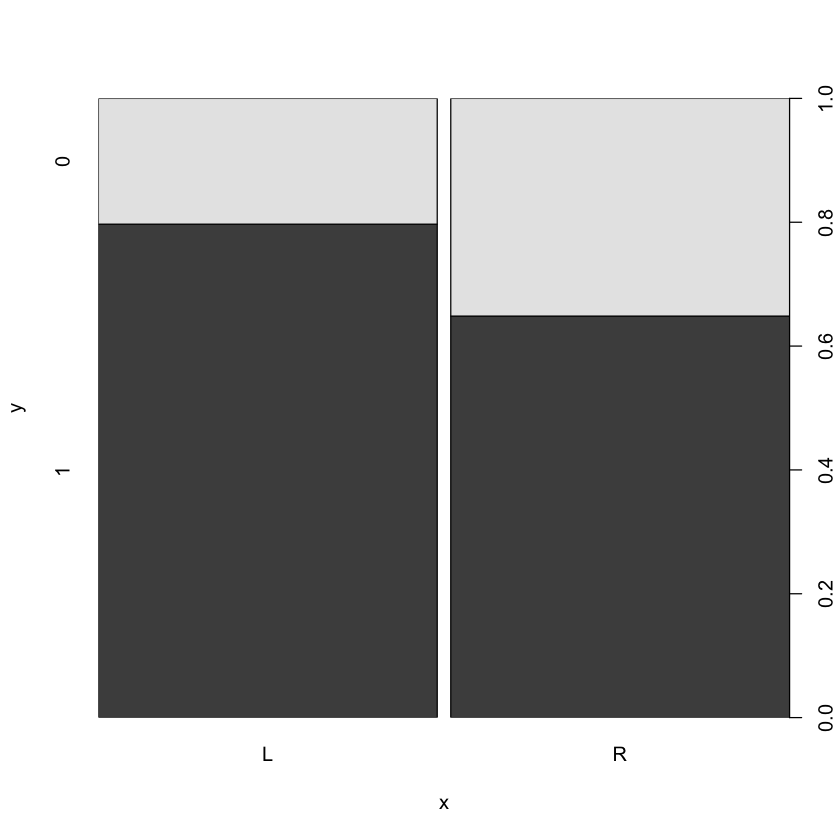

In [18]:
plot(ELP$Reward_Side, ELP$Final_Binary)

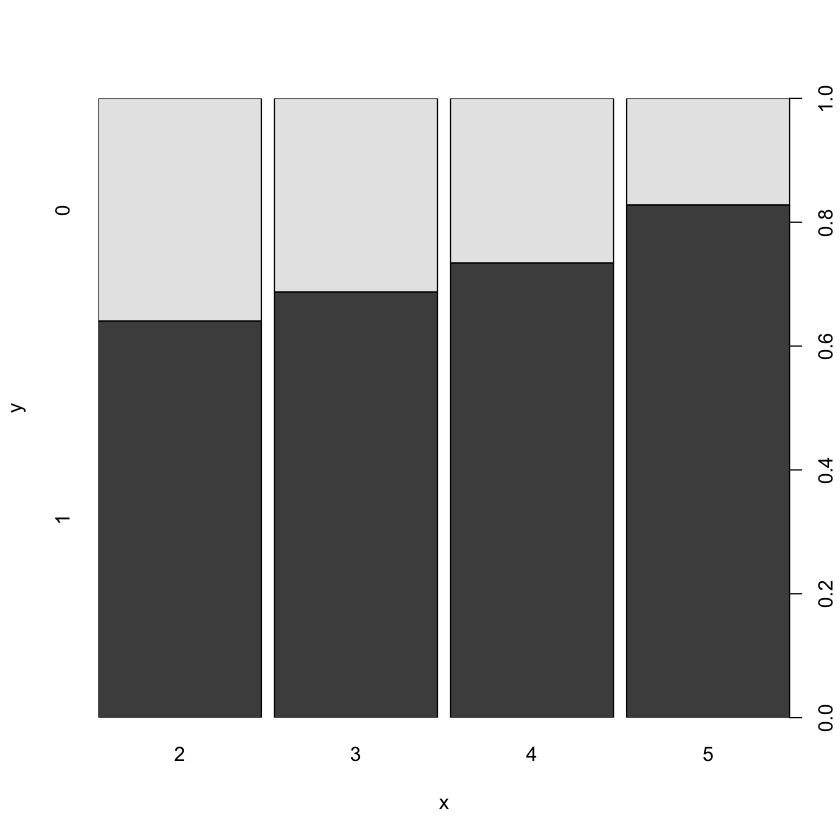

In [19]:
plot(ELP$Visit, ELP$Final_Binary)

## Initial Conclusions
- Consecutive visits seems to increase the number of ants choosing the reward side.
- There seems to be a side bias towards the Left.

## Brain lateralisation VS Visual Cues
**This setup had the wall on the Right!**

## Model averaging

In [20]:
confset(cand.set = cand_models) # Remove models that explain the last 0.05 Cum.Wt

,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,side_mod,7,309.6082,0.000000,1.00000000,0.67975814,-147.5783,0.6797581
7,max_mod,13,313.1174,3.509245,0.17297251,0.11757947,-142.8066,0.7973376
3,solution_mod,7,314.3847,4.776536,0.09178851,0.06239399,-149.9666,0.8597316
2,visit_mod,9,314.5822,4.974014,0.08315848,0.05652765,-147.9252,0.9162593
1,null_mod,6,314.6242,5.016056,0.08142865,0.05535179,-151.1434,0.9716110


There is no clearly better model!

In [22]:
top_models = list("side_mod" = side_mod, 
                   "max_mod" = max_mod,
                   "solution_mod" = solution_mod,
                   "visit_mod" = visit_mod,
                   "null_mod" = null_mod)

modavgShrink(top_models, parm = "(Intercept)")
modavg(top_models, parm = "SolutionB-alanine", exclude = "SolutionB-alanine:TSM_Bin31-60")
modavgShrink(top_models, parm = "Visit3")
modavgShrink(top_models, parm = "Visit4")
modavgShrink(top_models, parm = "Visit5")
modavg(top_models, parm = "TSM_Bin31-60", exclude = "SolutionB-alanine:TSM_Bin31-60")
modavgShrink(top_models, parm = "Reward_SideR")
modavgShrink(top_models, parm = "SolutionB-alanine:TSM_Bin31-60")

Warning message in modavgShrink.AICglmerMod(top_models, parm = "(Intercept)"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
side_mod,7,309.6082,0.000000,1.00000000,0.69961961,-147.5783,1.3595064,0.2317398
max_mod,13,313.1174,3.509245,0.17297251,0.12101496,-142.8066,0.6545289,0.3976259
solution_mod,7,314.3847,4.776536,0.09178851,0.06421704,-149.9666,0.7523361,0.1894319
visit_mod,9,314.5822,4.974014,0.08315848,0.05817930,-147.9252,0.5871370,0.2668443
null_mod,6,314.6242,5.016056,0.08142865,0.05696908,-151.1434,0.9634427,0.1514040


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
max_mod,13,313.1174,0.000000,1.0000000,0.6533156,-142.8066,0.6617873,0.4131301
solution_mod,7,314.3847,1.267291,0.5306538,0.3466844,-149.9666,0.4314340,0.2818187


Warning message in modavgShrink.AICglmerMod(top_models, parm = "Visit3"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
side_mod,7,309.6082,0.000000,1.00000000,0.69961961,-147.5783,0.0000000,0.0000000
max_mod,13,313.1174,3.509245,0.17297251,0.12101496,-142.8066,0.2204636,0.3838800
solution_mod,7,314.3847,4.776536,0.09178851,0.06421704,-149.9666,0.0000000,0.0000000
visit_mod,9,314.5822,4.974014,0.08315848,0.05817930,-147.9252,0.2133846,0.3777806
null_mod,6,314.6242,5.016056,0.08142865,0.05696908,-151.1434,0.0000000,0.0000000


Warning message in modavgShrink.AICglmerMod(top_models, parm = "Visit4"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
side_mod,7,309.6082,0.000000,1.00000000,0.69961961,-147.5783,0.0000000,0.0000000
max_mod,13,313.1174,3.509245,0.17297251,0.12101496,-142.8066,0.4590231,0.3935413
solution_mod,7,314.3847,4.776536,0.09178851,0.06421704,-149.9666,0.0000000,0.0000000
visit_mod,9,314.5822,4.974014,0.08315848,0.05817930,-147.9252,0.4448493,0.3879627
null_mod,6,314.6242,5.016056,0.08142865,0.05696908,-151.1434,0.0000000,0.0000000


Warning message in modavgShrink.AICglmerMod(top_models, parm = "Visit5"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
side_mod,7,309.6082,0.000000,1.00000000,0.69961961,-147.5783,0.000000,0.0000000
max_mod,13,313.1174,3.509245,0.17297251,0.12101496,-142.8066,1.034636,0.4302477
solution_mod,7,314.3847,4.776536,0.09178851,0.06421704,-149.9666,0.000000,0.0000000
visit_mod,9,314.5822,4.974014,0.08315848,0.05817930,-147.9252,1.006219,0.4264337
null_mod,6,314.6242,5.016056,0.08142865,0.05696908,-151.1434,0.000000,0.0000000


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
max_mod,13,313.1174,0,1,1,-142.8066,0.2290258,0.3913273


Warning message in modavgShrink.AICglmerMod(top_models, parm = "Reward_SideR"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
side_mod,7,309.6082,0.000000,1.00000000,0.69961961,-147.5783,-0.7650163,0.2932537
max_mod,13,313.1174,3.509245,0.17297251,0.12101496,-142.8066,-0.7859005,0.3007965
solution_mod,7,314.3847,4.776536,0.09178851,0.06421704,-149.9666,0.0000000,0.0000000
visit_mod,9,314.5822,4.974014,0.08315848,0.05817930,-147.9252,0.0000000,0.0000000
null_mod,6,314.6242,5.016056,0.08142865,0.05696908,-151.1434,0.0000000,0.0000000


Warning message in modavgShrink.AICglmerMod(top_models, parm = "SolutionB-alanine:TSM_Bin31-60"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
side_mod,7,309.6082,0.000000,1.00000000,0.69961961,-147.5783,0.0000000,0.0000000
max_mod,13,313.1174,3.509245,0.17297251,0.12101496,-142.8066,-0.4119512,0.5803011
solution_mod,7,314.3847,4.776536,0.09178851,0.06421704,-149.9666,0.0000000,0.0000000
visit_mod,9,314.5822,4.974014,0.08315848,0.05817930,-147.9252,0.0000000,0.0000000
null_mod,6,314.6242,5.016056,0.08142865,0.05696908,-151.1434,0.0000000,0.0000000


## Odds
**If the odds is 1 there is no effect, therefore if the CI's cross 1 that is not a significant parameter**

**Intercept** = 3.2 [1.5, 7.0] -> **Ants do not choose an arm of the Y-maze randomly at Visit 2!**

**Solution** = 1.8 [0.8, 3.8] -> **Ants under the effect of B-alanine seem to have greater odds of choosing the reward side! - Not significant**

**Visit 3** = 1.0 [0.7, 1.5] -> There is no effect of Visit 3!

**Visit 4** = 1.1 [0.7, 1.7] -> There is no effect of Visit 4!

**Visit 5** = 1.2 [0.5, 2.8] -> There is no effect of Visit 5!

**Side** = 0.5 [0.2, 1.2] -> There is no effect of Side!

**TSM** = 1.3 [0.6, 2.7] -> There is no effect of Time Since Marking!

**SolutionxTSM** = 1.0 [0.6, 1.5] -> There is no effect of the interaction of Solution with Time Since Marking!

## Conclusions
- Ants do not choose a random side of the Y-maze from Visit 2 showing a slight increase in the odds of choosing the reward side as the number of consecutive visits increases suggesting the ants are able to associate the reward with a side.
- There is no effect of Time Since Marking on final choice.
- There is no efect of B-alanine on final choice. Although it seems to increase the odds of choosing the reward side.
- There is no statistically significant side bias although there is a preference towards Left.
- There is no interaction effect of Solution with Time Since Marking.